# Image Classifier

In [62]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [63]:
from fastai.vision import *
from fastai.metrics import error_rate

In [161]:
import pandas as pd
import os
import matplotlib.image as mpimg
from PIL import Image
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch
import pickle
import os
import torchvision
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [65]:
data_path = "./data"
train_images_path = "{0}/train_image.pkl".format(data_path)
test_images_path = "{0}/test_image.pkl".format(data_path)
train_labels_path = "{0}/train_label.pkl".format(data_path)
batch_size = 64

In [66]:
def path_exists(path):
    """
     Function to verfiy if, file path defined is correct
    """
    return os.path.exists(path)

valid_path = [path_exists(_) for _ in (train_images_path, test_images_path, test_images_path)]
valid_path

[True, True, True]

In [155]:
class DataSetLoader(Dataset):
    '''DataSet Loader'''
    def __init__(self, train_path, labels_path=None, transform=None):
        """
        Args:
            train_path (string): Path to the training data file
            labels_path (string): Path to the labels present for the training data
            transform (callable): Optional transform to apply to sample
        """
        with open(train_path, 'rb') as file:
            training_images = np.array(pickle.load(file))
            
        with open(train_path, 'rb') as file:
            labels = np.array(pickle.load(file))
        
        self.X = self._load_from_pickle(train_path)
        pixel_size = self._get_file_dimension(self.X)
        # resize
        self.X = self.X.reshape(-1, 1, pixel_size, pixel_size)
        if labels_path:
            self.Y = self._load_from_pickle(labels_path, no_tensor=True)
        else:
            self.Y = None
            
        self.transform = transform
        
    def __len__(self):
        return len(self.X);
    
    def __getitem__(self, idx):
        item = self.X[idx];
        label = self.Y[idx];
        if self.transform:
            item = self.transform(item);
        
        return (item, label)
    
    def _load_from_pickle(self, file_path, no_tensor=False):
        """
         file_path: File path to load data, returns an ndarray
        """
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
        return data if no_tensor else torch.tensor(data)
    
    def _get_file_dimension(self, data):
        data_points, vector_size = data.shape
        return int(np.sqrt(vector_size))
    
    def get_labels(self):
        if self.Y is not None:
            return np.unique(self.Y)
        return []

In [156]:
# Creating a labels map for storing the labels
labels_map = {0 : 'T-Shirt', 2 : 'Pullover', 3 : 'Dress', 6 : 'Shirt'}
img_transforms = transforms.Compose(get_transforms())

In [157]:
train_dataset = DataSetLoader(train_images_path, labels_path=train_labels_path)
test_dataset = DataSetLoader(test_images_path)

In [158]:
labels = train_dataset.get_labels()
for label in labels:
    print("Label: {0}, value: {1}".format(label, labels_map[label]))

Label: 0, value: T-Shirt
Label: 2, value: Pullover
Label: 3, value: Dress
Label: 6, value: Shirt


In [159]:
trainloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

testloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

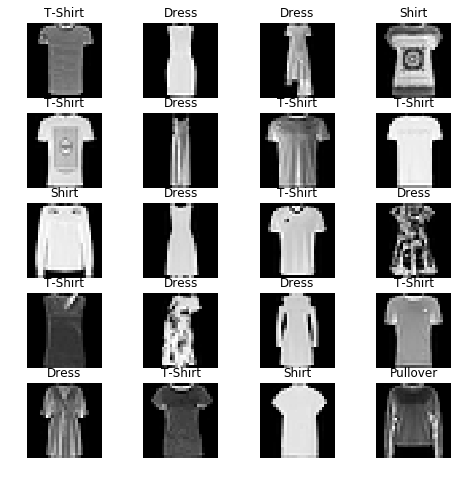

In [160]:
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()